In [19]:
import matplotlib
# %matplotlib inline
# print("BACKEND: ", matplotlib.get_backend())
# if matplotlib.get_backend() != "macosx":
#   print("Changing backend to macosx")
#   matplotlib.use('macosx')


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.visualize import view

from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

In [21]:
from agox.models.descriptors.fingerprint import Fingerprint
from agox.models.descriptors import Voronoi
import numpy as np

template = Atoms("", cell=np.eye(3) * 3.567, pbc=True)
diamond = bulk("C", "diamond", a=3.567)  # Lattice constant for diamond cubic carbon
confinement_cell = template.cell.copy()
confinement_corner = np.array([0, 0, 0])
environment = Environment(
    template=template,
    symbols="C8",
    confinement_cell=confinement_cell,
    confinement_corner=confinement_corner,
    box_constraint_pbc=[True, True, True],  # Confinement is periodic in all directions.
)
descriptor = Fingerprint(environment=environment)
graph_descriptor = Voronoi(
    covalent_bond_scale_factor=1.3, n_points=8, angle_from_central_atom=20, environment=environment
)


╭───────────────────────────── Environment report ─────────────────────────────╮
│ Atoms in search:                                                             │
│     C = 8                                                                    │
│ Template formula:                                                            │
│ Full formula: C8                                                             │
│ Cell:                                                                        │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
│ Periodicity:                                                                 │
│     True True True                                                           │
│ Box constraint: True                                                         │
│ Confinement corner                                                           │
│     0.00 0.00 0.00                                                           │
│ Confinement cell:                                                            │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
╰──────────────────────────────────────────────────────────────────────────────╯

In [22]:
from chgnet.model import CHGNetCalculator
calc = CHGNetCalculator()

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [23]:
graph_sorting = Analysis(descriptor=graph_descriptor, directories=["."], sample_size=40)

In [24]:
seed = 1
rlxd_string = "rlxd"

In [25]:
# # structures = read("DMACE/D3-5/all.traj", index=":")
# structures = read("all.traj", index=":")
structures = read("DTMP/"+rlxd_string+"_structures_seed"+str(seed)+".traj", index=":")
for structure in structures:
  structure.calc = calc

In [ ]:
unique, count = graph_sorting.sort_structures(structures=structures)
print("Repeats of unique structures: ", count)

In [ ]:
# Calculate energies per atom for each unique structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in unique]
delta_en_per_atom = np.array(energies_per_atom) - (-9.064090728759766)


In [10]:
if abs( np.min(energies_per_atom) + 9.064090728759766 ) > 1e-4:
  print("Minimum energy per atom is not zero. Check the energy calculation.")
  exit()

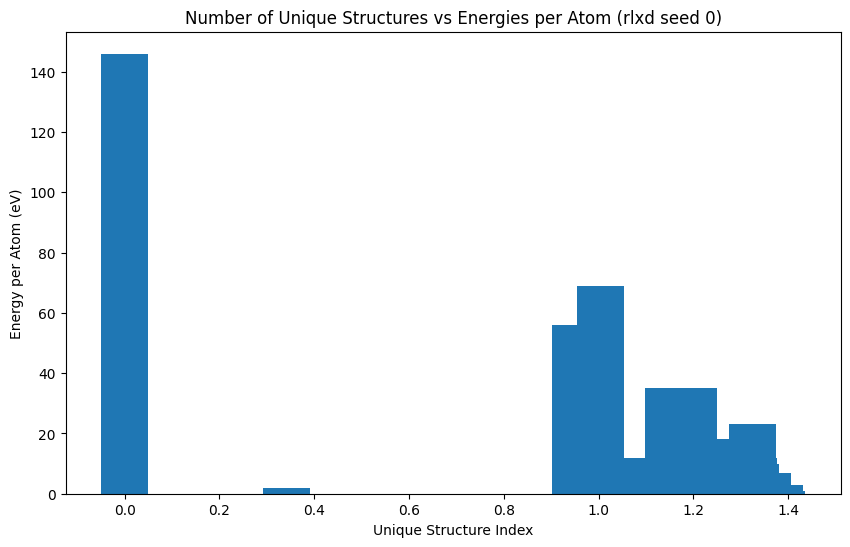

In [11]:
# Plot the number of unique structures vs the energies per atom
plt.figure(figsize=(10, 6))
plt.bar(delta_en_per_atom, count, width=0.1)
plt.xlabel('Unique Structure Index')
plt.ylabel('Energy per Atom (eV)')
plt.title('Number of Unique Structures vs Energies per Atom ('+rlxd_string+' seed '+str(seed)+')')
# plt.show()
plt.savefig("unique_structures_vs_energies_per_atom_"+rlxd_string+"_seed"+str(seed)+".png")

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)

In [14]:
# graph_descriptor.get_features(unique[0])
if rlxd_string == "unrlxd" and seed == 0:
  pca.fit(np.squeeze([arr for arr in descriptor.get_features(unique)]))

In [15]:
# save pca model
import pickle
if False: #rlxd_string == "unrlxd" and seed == 0:
  with open("pca_model_"+rlxd_string+"_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

# load pca model
with open("../DRAFFLE/pca_model_unrlxd_0.pkl", "rb") as f:
  pca = pickle.load(f)


In [16]:
X_reduced = pca.transform(np.squeeze([arr for arr in descriptor.get_features(unique)]))

In [17]:
plt.figure(1, figsize=(8, 6))
#plt.figure(figsize=(10, 6))
#plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=delta_en_per_atom, cmap="viridis")

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

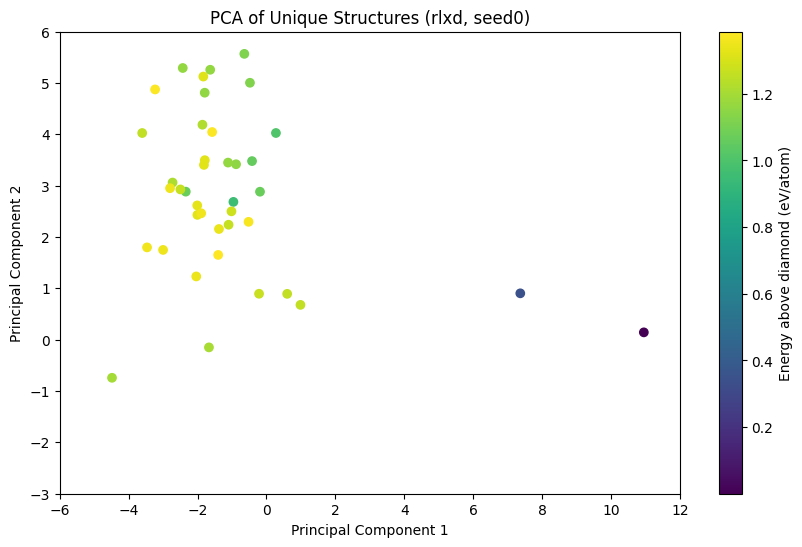

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=delta_en_per_atom, cmap="viridis")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Unique Structures ('+rlxd_string+', seed'+str(seed)+')')
plt.xlim(-6, 12)
plt.ylim(-3, 6)
plt.colorbar(label='Energy above diamond (eV/atom)')
plt.savefig('pca_unique_structures_'+rlxd_string+'_seed'+str(seed)+'.png')